### Example notebook demonstrating how to use the phenomic-ai package to infer embeddings wrt. a single cell RNA .h5ad file

In [2]:
import os
import pandas as pd
import seaborn as sns
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt

In [3]:
! pip install -U phenomic-ai  # install/update phenomic-ai dependency/package  # https://pypi.org/project/phenomic-ai/

In [4]:
# import from pai (phenomic-ai dependency/package alias)
from pai.utils.option_choices import tissue_organ_option_choices
from pai.embed import PaiEmbeddings

tmp_dir = "./tmp"  # temporary directory is the root output directory where the downloaded zip files (zips/) and unzipped directories (results/) will be output
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)

print(tissue_organ_option_choices)  # tissue/organ option choices
pai_embeddings = PaiEmbeddings(tmp_dir=tmp_dir)  # init w/ temporary directory

['adipose', 'adrenal gland', 'bile duct', 'bladder', 'blood', 'brain', 'breast', 'colorectal', 'eye', 'head and neck', 'heart', 'intestine', 'kidney', 'liver', 'lung', 'lymph-node', 'marrow', 'muscle', 'ovaries', 'pancreas', 'placenta', 'pleura', 'prostate', 'salivary gland', 'skin', 'spleen', 'stomach', 'testis', 'thymus', 'thyroid gland', 'uterus', 'vasculature']


In [ ]:
# wget example scRNA dataset from cellxgene


!wget -P {tmp_dir} https://datasets.cellxgene.cziscience.com/0fd9c007-8ba2-4d87-8568-c938d2631fba.h5ad 

# specify download path
h5ad_path = os.path.join(tmp_dir,"0fd9c007-8ba2-4d87-8568-c938d2631fba.h5ad")  # h5ad path is the path to the single cell RNA .h5ad file intended to be uploaded and embeded


--2025-07-20 06:04:57--  https://datasets.cellxgene.cziscience.com/0fd9c007-8ba2-4d87-8568-c938d2631fba.h5ad
Resolving datasets.cellxgene.cziscience.com (datasets.cellxgene.cziscience.com)... 108.156.172.118, 108.156.172.19, 108.156.172.53, ...
Connecting to datasets.cellxgene.cziscience.com (datasets.cellxgene.cziscience.com)|108.156.172.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 591123472 (564M) [binary/octet-stream]
Saving to: ‘./tmp/0fd9c007-8ba2-4d87-8568-c938d2631fba.h5ad.1’

0fd9c007-8ba2-4d87- 100%[===================>] 563.74M   330MB/s    in 1.7s    

2025-07-20 06:04:59 (330 MB/s) - ‘./tmp/0fd9c007-8ba2-4d87-8568-c938d2631fba.h5ad.1’ saved [591123472/591123472]



07/20/2025 06:04:59 AM Checking destination folders...
07/20/2025 06:04:59 AM Uploading h5ad file...
07/20/2025 06:04:59 AM Getting upload id
07/20/2025 06:04:59 AM Recieved uuid: e859ff22-f31f-4488-a420-7b4dc648b6df
07/20/2025 06:06:06 AM Upload complete, job id: 69d5f449bccf4fe1bdd206d1c8a8700e
07/20/2025 06:06:06 AM Listening for job status
07/20/2025 06:06:06 AM Job status: SUBMITTED
07/20/2025 06:06:16 AM Job status: VALIDATING
07/20/2025 06:06:26 AM Job status: RUNNING
07/20/2025 06:06:36 AM Job status: RUNNING
07/20/2025 06:06:46 AM Job status: RUNNING
07/20/2025 06:06:56 AM Job status: RUNNING
07/20/2025 06:07:06 AM Job status: RUNNING
07/20/2025 06:07:16 AM Job status: RUNNING
07/20/2025 06:07:26 AM Job status: RUNNING
07/20/2025 06:07:36 AM Job status: RUNNING
07/20/2025 06:07:46 AM Job status: RUNNING
07/20/2025 06:07:56 AM Job status: RUNNING
07/20/2025 06:08:06 AM Job status: RUNNING
07/20/2025 06:08:16 AM Job status: RUNNING
07/20/2025 06:08:26 AM Job status: RUNNING
07/2

In [ ]:
# Ensure column or named 'gene' or index values are common gene names

ad = sc.read_h5ad(h5ad_path)
ad.var['gene'] = ad.var['feature_name']
ad.var.set_index('feature_name',inplace=True)
ad.write_h5ad(h5ad_path)


In [ ]:
# Run inference
tissue_organ = "lung"  # tissue/organ specifies the tissue/organ associated wrt. the single cells

pai_embeddings.inference(h5ad_path=h5ad_path, tissue_organ=tissue_organ)

In [16]:
# List results - make sure result ID is copied over to next cell to load in embeddings result

res_dir = os.path.join(tmp_dir,'results')
os.listdir(res_dir)

['0fd9c007-8ba2-4d87-8568-c938d2631fba-lung-2025-07-20-T06:10:17']

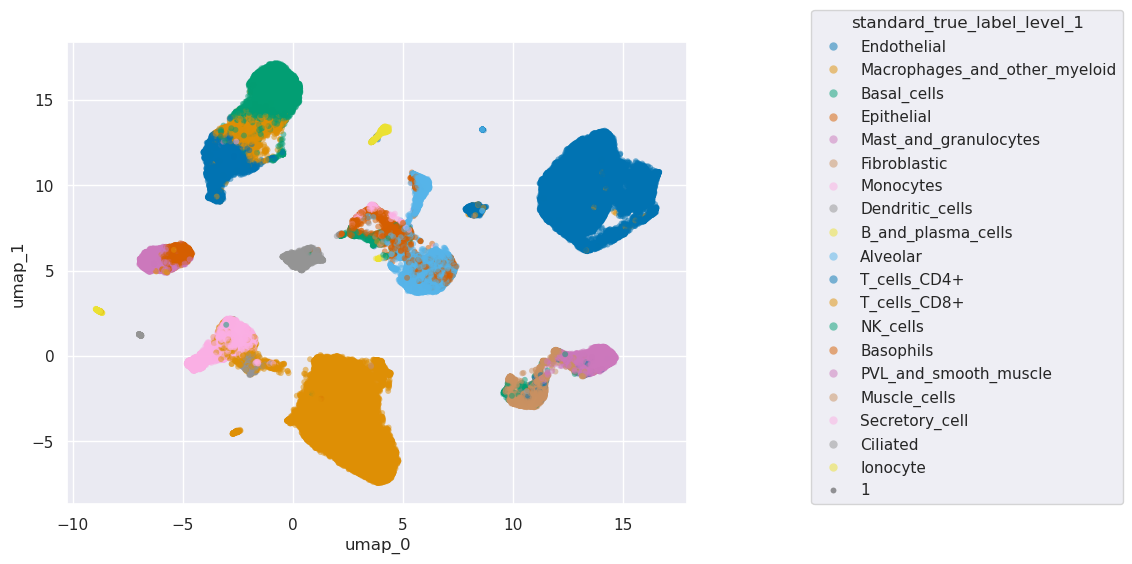

In [ ]:
# Plot UMAP projections of embedding results alongside predicted cell-type label

# Replace with local path to results.csv

embeddings = pd.read_csv(os.path.join(res_dir,'0fd9c007-8ba2-4d87-8568-c938d2631fba-lung-2025-07-20-T06:10:17','results.csv'))
embeddings = embeddings.set_index('barcode')

sns.set_theme(rc={'figure.figsize':(8,6)})
ax = sns.scatterplot(x=embeddings['umap_0'],
                y=embeddings['umap_1'],
                hue=embeddings['standard_true_label_level_1'],
                linewidth=0,palette='colorblind',
                size=1,alpha=0.5)

sns.move_legend(
    ax, loc=(1.2,0.)
)

In [ ]:
# Overlay some commonly expressed genes on the UMAP projection

ad = sc.read_h5ad(h5ad_path)
new_obs = ad.obs.join(embeddings)

for gene in ['EPCAM','CD3E','MARCO','COL1A1','JCHAIN']:
    
    exp_vec = np.asarray(ad[:,ad.var['feature_name'] ==gene].X.todense()).flatten()
    inds = np.argsort(exp_vec)
    sns.scatterplot(x=new_obs['umap_0'][inds],
                    y=new_obs['umap_1'][inds],
                    hue=exp_vec[inds],linewidth=0,
                    size=1,alpha=0.5)
    plt.show()

### Align in a second dataset

In [ ]:
# wget a 2nd example scRNA dataset from cellxgene
# https://cellxgene.cziscience.com/collections/2b02dff7-e427-4cdc-96fb-c0f354c099aa

!wget -P {tmp_dir} https://datasets.cellxgene.cziscience.com/51c53821-7889-4491-a2fd-9101e3bc9e3a.h5ad# List results - make sure result ID is copied over to next cell to load in embeddings result

res_dir = os.path.join(tmp_dir,'results')
os.listdir(res_dir)

In [ ]:
# Run inference  

h5ad_path_2 = os.path.join(tmp_dir,"51c53821-7889-4491-a2fd-9101e3bc9e3a.h5ad")  # h5ad path is the path to the single cell RNA .h5ad file intended to be uploaded and embeded
tissue_organ = "intestine"  # tissue/organ specifies the tissue/organ associated wrt. the single cells

pai_embeddings.inference(h5ad_path=h5ad_path_2, tissue_organ=tissue_organ)

In [ ]:
# List results - make sure result ID is copied over to next cell to load in embeddings result

res_dir = os.path.join(tmp_dir,'results')
os.listdir(res_dir)

In [ ]:
# Load in 2nd embedding results alongside predicted cell-type label

embeddings_2 = pd.read_csv(os.path.join(res_dir,'51c53821-7889-4491-a2fd-9101e3bc9e3a-intestine-20240918','results.csv'))
embeddings_2 = embeddings_2.set_index('barcode')

embeddings['study'] = 'lung'
embeddings_2['study'] = 'intestine'

embeddings_combined = pd.concat([embeddings,embeddings_2])

In [ ]:
# Run UMAP on combined embeddings

import umap.umap_ as umap

proj = umap.UMAP().fit_transform(embeddings_combined[['embedding_'+str(i) for i in range(10)]])

In [ ]:
# Plot UMAP projections of embedding results alongside predicted cell-type label

sns.set_theme(rc={'figure.figsize':(8,6)})
sns.scatterplot(x=proj[:,0],
                y=proj[:,1],
                hue=embeddings_combined['study'],
                linewidth=0,palette='colorblind',
                size=2,alpha=0.2)


In [ ]:
# Plot UMAP projections of embedding results alongside predicted cell-type label

sns.set_theme(rc={'figure.figsize':(8,6)})
ax = sns.scatterplot(x=proj[:,0],
                y=proj[:,1],
                hue=embeddings_combined['standard_true_label_level_1'],
                linewidth=0,palette='colorblind',
                size=1,alpha=0.2)

sns.move_legend(
    ax, loc=(1.2,0.)
)